#**ECE 4554 / ECE 5554 / Computer Vision**
This file contains the coding problems (Problems 5 and 6) for Homework 2. Your job is to implement/modify the sections within this notebook that are marked with "TO DO".

##**TO DO**: Enter your Virginia Tech Username (PID) here: benakhtar
Do not write a student ID number. Your Username is normally part of your @vt.edu email address.

##**Honor Code reminder**
This is not a "team project". Please review the Honor Code statement in the syllabus.  Also, if you make use of code from ANY source except the instructor, you must provide comment lines in your code blocks to state where you obtained that code. Failure to cite sources of code that you borrowed will be considered a violation of the Honor Code.

##Code libraries
You are allowed to use NumPy and Matplotlib functions to perform matrix
operations and graphics/plotting operations. You are also allowed to use any OpenCV functions that are provided in this start-up notebook, but do not use any other OpenCV functions without permission from the instructor.

##**Submission guidelines** for the coding problems (Google Colab)

1. Please verify that you have entered your Virginia Tech Username in all of the appropriate places.
2. After clicking Runtime->Run all, verify that all of your solutions are visible in this notebook.
3. Click File->Save near the top of the page to save the latest version of your notebook at Google Drive.
4. Verify that the last 2 cells have executed, creating a PDF version of this notebook at Google Drive. (Note: if you face difficulty with this step, please refer to https://pypi.org/project/notebook-as-pdf/)
5. Look at the PDF file and check that all of your solutions are displayed correctly there.
6. Download your notebook file and the PDF version to your laptop.
7. If needed, change the file names to Homework2_USERNAME.ipynb and Homework2_Notebook_USERNAME.pdf, using your own Username. Don't zip either of the files.
6. **Submit these 2 files and your PDF file for Problems 1-4 SEPARATELY to Canvas.** Do not zip them all together.

##**Overview**

For Problem 5, you will write code to find a 2D homography and to perform image warping.

Problem 6 requires you to use your code from the first problem to perform a "bird's-eye-view" transformation.

# Environment setup

In [47]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Change the directory to your own working directory
# Your code will be able to read & write files in your working directory
# TO DO: If needed, edit the 'chdir' line to provide your Google-Drive␣directory name
import os
os.chdir('/content/drive/My Drive/Computer Vision')


In [49]:
# Import library modules
import sys
import cv2 # OpenCV library
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # PIL is the Python Imaging Library

# The following is a substitute for cv2.imshow,
#  which you would use on your local machine but Colab does not support it
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
OpenCV version: 4.8.0
NumPy version:  1.23.5


#Getting started

Several image files have been provided to you as part of this assignment: mandrill.png, Rubiks_cube.jpg, image1.png, image2.png. Upload all of them to your working directory.

The following functions are helpful for loading images into floating-point format, and for displaying images that are in that format.  Use those functions to verify that the files can be accessed and displayed. Notice that you can adjust the size of the figure that is displayed.


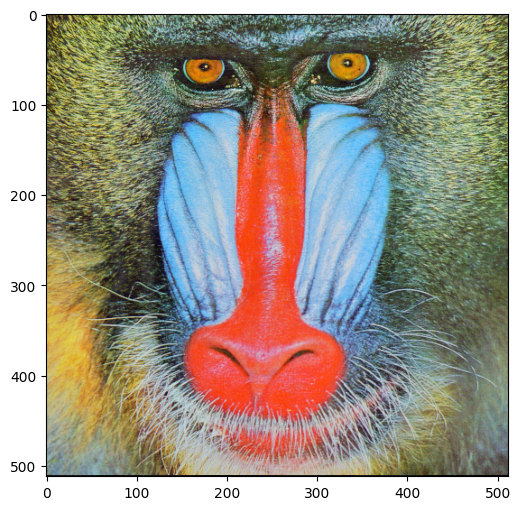

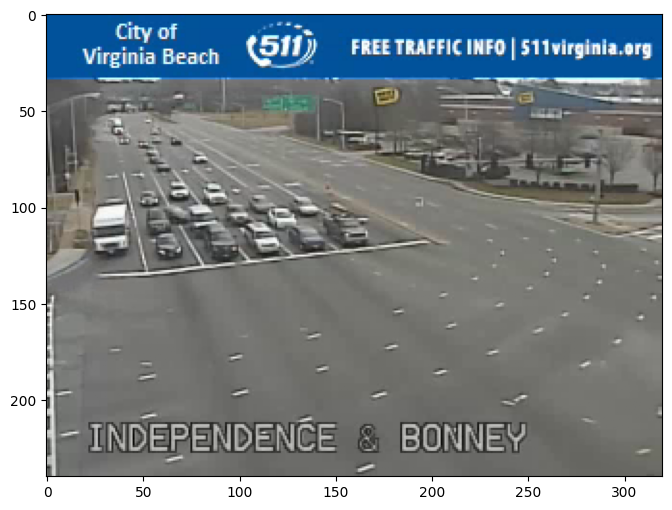

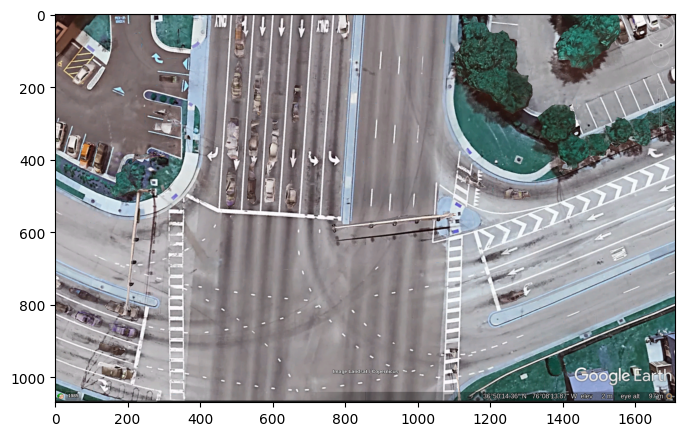

In [50]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(8, 6) # You can adjust the size of the displayed figure
  plt.imshow(img)

# A mandrill is “a large fierce gregarious baboon of western Africa”
mandrill_image = load_image('mandrill.png')
# The next image file is a screen-shot from Virginia Dept. of Transportation's
#  publicly available traffic videos, https://www.511virginia.org/
image1 = load_image("image1.png")
# The next image file is from Google Earth, and it has an "alpha" channel in addition to RGB channels;
#  the following lines remove the alpha channel from our internal representation
image2 = load_image("image2.png")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGRA2RGB)

show_image(mandrill_image)
show_image(image1)
show_image(image2)

#Problem 5 (10 points)
**a) 2D homography**

Implement the 2 functions that are shown in the next code block. Both functions will be needed in Problem 5 and in Problem 6. (OpenCV has a findHomography() function and other related functions, but for this assignment you must write your own versions.)

1.   **compute_homography(src, dst)** receives two matrices, each of size Nx2. Each matrix contains N two-dimensional points. For each value of i, src[i] and dst[i] are corresponding points from two different images. The function should return the homography matrix H of size 3x3 that maps every point from the source (src) to the destination (dst). You may assume that N is at least 4. For more guidance, refer to Problem 4 in this assignment.
2.   **apply_homography(src, H)** receives points in matrix named src (an Nx2 matrix), and a homography transformation H (a 3x3 matrix). This function should use the homography matrix to transform each point in src to a new destination point. Store the resulting points in matrix dst, which is the same size as src. The function should return dst.



In [51]:
##############################
# TO DO: Implement the compute_homography function

def compute_homography(src, dst):
  '''Computes the homography from src to dst.
   Input:
    src: source points, shape (N, 2), where N >= 4
    dst: destination points, shape (N, 2)
   Output:
    H: homography from source points to destination points, shape (3, 3)
  '''

  # SOURCE: https://math.stackexchange.com/questions/3509039/calculate-homography-with-and-without-svd

  x = []
  y = []
  x_prime = []
  y_prime = []

  # build our point matrices
  for item in range(0, len(src)):
      x.append(src.item(2 * item))
      y.append(src.item(2 * item +1 ))
      x_prime.append(dst.item(2 * item))
      y_prime.append(dst.item(2 * item + 1))
  # creates an A of necessary length
  A = np.zeros([2 * len(x), 9])

  # builds A and then finds H using SVD
  for item in range(0, (len(x))):
      A[item * 2]     = [-x[item], -y[item], -1, 0,        0,         0, x[item] * x_prime[item], y[item] * x_prime[item], x_prime[item]]
      A[item * 2 + 1] = [0,        0,         0, -x[item], -y[item], -1, x[item] * y_prime[item], y[item] * y_prime[item], y_prime[item]]
  [U, S, Vt] = np.linalg.svd(A)
  H = Vt[-1].reshape(3, 3)

  return H

##############################
# TO DO: Implement the apply_homography function

def apply_homography(src, H):
  '''Applies a homography H to the source points.
   Input:
      src: source points, shape (N, 2)
      H: homography from source points to destination points, shape (3, 3)
   Output:
     dst: destination points, shape (N, 2)
  '''
  # creates our destination image
  dst = np.empty_like(src, dtype=np.float128)
  dst = np.asarray(dst)
  #gets the current source point
  current_src = np.empty([3, 1])
  current_src[2][0] = 1
  H_mat = np.asmatrix(H)
  for x in range(0, len(src)):
      # goes through each point in the source to find the destination point that would match
      current_src[0][0] = src.item(x*2)
      current_src[1][0] = src.item(2*x +1)

      current_src_mat = np.asmatrix(current_src)

      prime = np.matmul(H_mat, current_src_mat)
      dst[x][0] = prime.item(0)/prime.item(2)
      dst[x][1] = prime.item(1)/prime.item(2)

  return dst

You do not need to change the following function. It will test your homography code, and should help you in debugging. Corresponding points are placed in src_pts and dst_pts. If your homography code is correct, it should map the points given in test_pts to locations that are close to the points given in match_pts_correct. If you have correctly implemented compute_homography() and apply_homography(), then the printed difference values should be close to 0. (For full credit, the reported difference should be no larger than 0.001.)

In [52]:
def test_homography():
  src_pts = np.matrix('0, 0; 1, 0; 1, 1; 0, 1')
  dst_pts = np.matrix('3, 2; 3.67, 2; 3.5, 2.5; 3, 3')
  H = compute_homography(src_pts, dst_pts)
  test_pts = src_pts
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = dst_pts
  print('Your 1st solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())

  src_pts = np.matrix('0, 0; 1, 0; 1, 1; 0, 1; 2, 3')
  dst_pts = np.matrix('3, 2; 3.67, 2; 3.5, 2.5; 3, 3; 3.5, 2.75')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('0,  0; 1, 0; 1, 1; 0, 1')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('3, 2; 3.67, 2; 3.5, 2.5; 3, 3')
  print('Your 2nd solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())

  src_pts = np.matrix('347, 313; 502, 341; 386, 571; 621, 508')
  dst_pts = np.matrix('274, 286; 436, 305; 305, 527; 615, 506')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('259, 505; 350, 371; 400, 675; 636, 104')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('195.13761083, 448.12645033;'
    '275.27269386, 336.54819916;'
    '317.37663747, 636.78403426;'
    '618.50438823, 28.78963905')
  print('Your 3rd solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())

test_homography()


Your 1st solution differs from our solution by: 0.000000
Your 2nd solution differs from our solution by: 0.000002
Your 3rd solution differs from our solution by: 0.000000


**b)  Image warping using a 2D homography**

Implement the following function so that it performs image warping from a source image (src_img) to a newly created destination image (dst_img). Do not use any additional OpenCV functions.

*Please note:* The homography H that is provided indicates a desired mapping from src_img to dst_img. To prevent gaps in the output image, however, it is suggested that your implementation should iterate over all pixels in dst_img. In that case, your code should use the *inverse* of H to find values in src_img as it iterates over dst_img.

In [53]:
##############################
# TO DO: Implement the warp_img function

def warp_img(src_img, H, dst_img_size):
  '''Warping of a source image using a homography.
   Input:
      src_img: source image with shape (m, n, 3)
      H: homography, with shape (3, 3), from source image to destination image
      dst_img_size: height and width of destination image; shape (2,)
   Output:
      dst_img: destination image; height and width specified by dst_img_size parameter
  '''

  src_img_size = src_img.shape

  dst_img_size_mod = [dst_img_size[0], dst_img_size[1], 3]
  dst_img = np.ones(dst_img_size_mod)

  H_inverse = np.linalg.inv(H)
  for x in range(0, dst_img_size[0]):
    for y in range(0, dst_img_size[1]):
      #use x,y instead of [x][y]
      # need to stick x, y, 1 for a 3x1 matrix
      #so basically, think of x, y, 1 as the cordinates we have, then use H-inverse to map back to the src image and get the intensity from that specific pixel
      destination_matrix = np.array([x, y, 1])
      src_image_point = np.matmul(H_inverse, destination_matrix)
      x_src = int(src_image_point.item(0) / src_image_point.item(2))
      y_src = int(src_image_point.item(1) / src_image_point.item(2))

      #basically, if the bounds are not relevant (outside of where it can be placed), we want to set to 0

      if x_src > dst_img_size[0]-1 or y_src > dst_img_size[1]-1 or x_src < 0 or y_src < 0 or x_src > src_img_size[0]-1 or y_src > src_img_size[1]-1:
        intensity = [0, 0, 0]
      else:
        intensity = src_img[x_src][y_src]

      # set the intensity of that point
      dst_img[x,y] = intensity
  return dst_img


The following will test your image_warp function by performing a  rotation. Do not change any code in the following block. If your code is correct, the output here should show a mandrill image that has been rotated by 10 degrees counterclockwise about the upper-left corner.


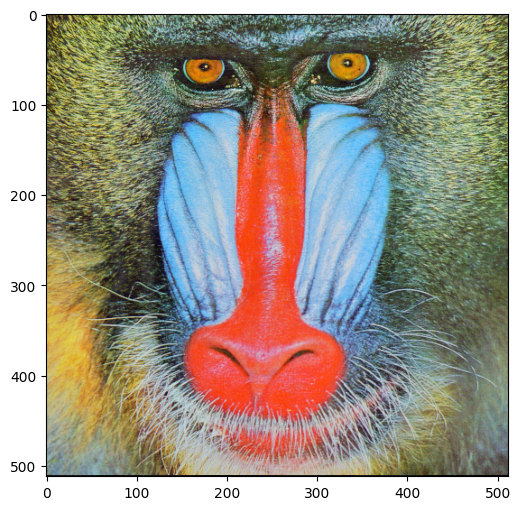

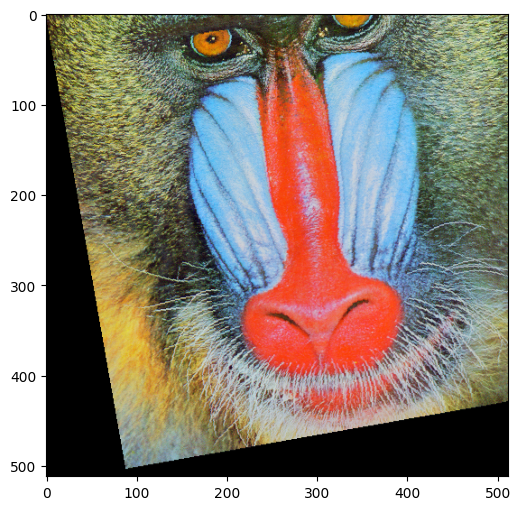

In [54]:
def test_rotation():
  src_img = load_image('mandrill.png')
  canvas_img = np.zeros([src_img.shape[0], src_img.shape[1], 3])

  theta = 10  # counterclockwise rotation angle in degrees
  H = np.mat([[np.cos(theta * np.pi/180), -np.sin(theta * np.pi/180), 0.0],
       [np.sin(theta * np.pi/180), np.cos(theta * np.pi/180), 0.0],
       [0.0, 0.0, 1.0]])
  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])
  show_image(src_img)

  show_image(dst_img)

test_rotation()

**c)  Rotation about an arbitrary point**

Implement the following function so that it rotates an image about an arbitrary point (x0, y0). This solution must make use of your warp_img function.

You can base your answer closely on the  function test_rotation that was provided to you. The main difference is that your code should compute H using matrix multiplication, with matrices that match your answer to Problem 2.







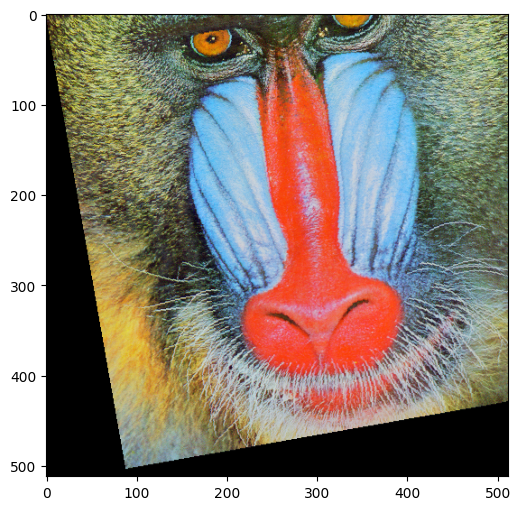

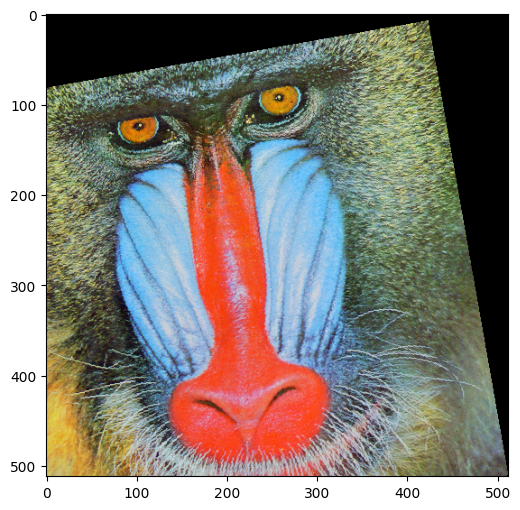

In [56]:
##############################
# TO DO: Implement the following function
def test_rotation2(x0, y0):
  '''Rotate the mandrill image about arbitrary point (x0, y0).
     See the description above.
  '''

  # It was not specified which image should be used as source or what theta is. I have used the same values as the previous problem.
  src_img = load_image('mandrill.png')
  canvas_img = np.zeros([src_img.shape[0], src_img.shape[1], 3])
  theta = 10

  # Get the three matrices and multiply together to get our H

  T2 = np.matrix([[1, 0, x0], [0, 1, y0], [0, 0, 1]])
  R  = np.matrix([[np.cos(theta * np.pi/180), -np.sin(theta * np.pi/180), 0.0],
       [np.sin(theta * np.pi/180), np.cos(theta * np.pi/180), 0.0],
       [0.0, 0.0, 1.0]])
  T1 = np.matrix([[1, 0, -x0], [0, 1, -y0], [0, 0, 1]])
  H = np.matmul(T2, np.matmul(R, T1))

  # Perform the rotation
  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])

  show_image(dst_img)

####################################
#These test cases should rotate about the upper left corner, and about the lower right corner.
test_rotation2(0, 0)
test_rotation2(511, 511)


**d)  Another test case**

The following will test your image_warp function with a more general homography. You do not need to modify these functions. If your code is correct, the output here should show a  mandrill image that has been warped to overlay the blue side of a Rubik's cube.

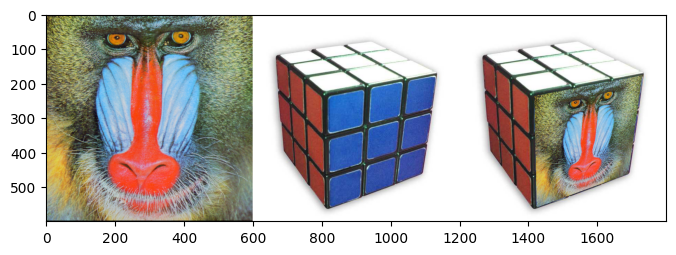

In [57]:
def binary_mask(img):
  '''Create a binary mask of the image content.
   Input:
    img: source image, shape (m, n, 3)
   Output:
    mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask,
      if pixel [i, j] in img is nonzero in any channel, assign 1 to mask[i, j].
      Else, assign 0 to mask[i, j].
  '''
  mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
  mask = mask.astype("int")
  return mask

def test_warp():
  src_img = load_image('mandrill.png')
  canvas_img = load_image('Rubiks_cube.jpg')

  # The following are corners of the mandrill image in (ROW, COLUMN) order
  src_pts = np.matrix('0, 0; 511, 0; 511, 511; 0, 511')
  # The following are corners of the blue face of the Rubik's cube
  canvas_pts = np.matrix('238, 218; 560, 225; 463, 490; 178, 530')

  # The following was used during debugging
  # It draws a circle at a location specified by (COLUMN, ROW)
  # cv2.circle(canvas_img, (530, 178), 4, (255, 0, 0), thickness=10)

  H = compute_homography(src_pts, canvas_pts)

  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])

  dst_mask = 1 - binary_mask(dst_img)
  dst_mask = np.stack((dst_mask,) * 3, -1)
  out_img = np.multiply(canvas_img, dst_mask) + dst_img

  dsize = (600, 600) # width and height of canvas_im
  src_smaller = cv2.resize(src_img, dsize, interpolation=cv2.INTER_AREA)

  warped_img = np.concatenate((src_smaller, canvas_img, out_img), axis=1)
  show_image(np.clip(warped_img, 0, 1))

test_warp()

#Problem 6 (10 points)

The images in files image1.png and image2.png show a particular roadway intersection near Virginia Beach.  The first image is from a traffic camera that is mounted on a pole near the intersection. The second image is from Google Earth, and represents a nadir view (vertically downward) from a satelite.

Write a function called bev() that will load both images and convert the traffic-camera image to a "bird's-eye view" of the same intersection. The new representation should align closely with the Google-Earth image. To demonstrate a correct mapping, your code should superimpose and display the computed result directly on the Google-Earth view.

Some notes:

1.   The idea for this problem is to perform image warping using a 2D homography matrix H that you compute, and using your warp_img function.
2. You may hard-code the file names inside this function.
3. You do not need to do automated detection of any keypoints. Instead, manually select several corresponding points from the 2 images. Next, call your compute_homography function to create H using your manually selected points.
4. When you select corresponding image points, take care that all of those points are from a planar surface in the 3D scene. If you select points from different 3D elevations, the homography math that we have been using does not apply.
5.   Because your code will map one image onto another for display purposes, you are implementing a version of image stitching, also called image compositing.
6. Some portions of the 3D scene that are visible in traffic-camera image are not visible in the satelite view. During your warp_img operation, simply ignore any bird's-eye-view points (computed from image1.png) that are not within the field of the satelite image (image2.png).
7. It is possible that you will not obtain perfect alignment between the two images. We should expect some geometric lens distortion from the traffic camera, for example.
8. This problem was inspired by  recent research at VTTI, the Virginia Tech Transportation Institute. A grad student, Akash Sonth, used this  transformation in his work that involved traffic safety. By using this
bird's-eye-view mapping, he was able to locate and track vehicles relative to geographic coordinates such as latitude and longitude. If interested, you can find his recent MS thesis at VT's ETD site, https://vtechworks.lib.vt.edu/handle/10919/116073.





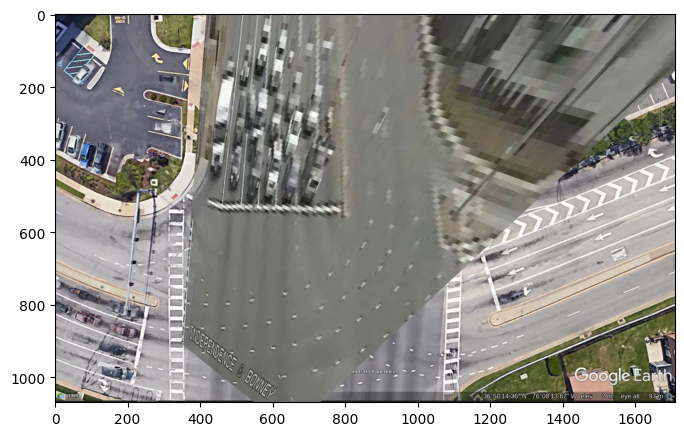

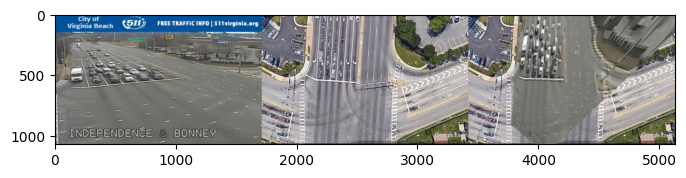

In [58]:
##############################
# TO DO: Implement the bev function

def bev():

  src_img = load_image('image1.png')
  canvas_img2 = load_image('image2.png')


  # Went to Office Hours, Danny said this was okay to use to convert from the RGBA to RGB
  canvas_img = cv2.cvtColor(canvas_img2, cv2.COLOR_RGBA2RGB)

  # Build the source point matrix
  src_pts = np.matrix('115, 295; 134, 52; 116, 314;  89, 205; 82, 73; 118, 197;  146, 3; 232, 3; 202, 240; 104, 316; 82, 182')
  # Build our destination point matrix
  canvas_pts = np.matrix('627, 1042; 539, 449; 652, 1084; 126, 1071; 51, 623; 567, 788; 545, 353; 868, 351; 1038, 650; 463, 1216; 8, 1075')

  H = compute_homography(src_pts, canvas_pts)

  # will get the destination image
  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])

  # perform necessary masking
  dst_mask = 1 - binary_mask(dst_img)
  dst_mask = np.stack((dst_mask,) * 3, -1)
  out_img = np.multiply(canvas_img, dst_mask) + dst_img

  # our output combined image
  show_image(out_img)

  dsize = (1710, 1070) # width and height of canvas_im
  src_smaller = cv2.resize(src_img, dsize, interpolation=cv2.INTER_AREA)

  # Concatenate together to show off
  warped_img = np.concatenate((src_smaller, canvas_img, out_img), axis=1)
  show_image(np.clip(warped_img, 0, 1))

#############################
# Run the bev function
bev()

---
# Creating a PDF version of your current notebook

In [59]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc
!pip install --quiet pypandoc

In [60]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "/content/drive/My Drive/Computer Vision/Homework2_benakhtar.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Computer Vision/Homework2_benakhtar.ipynb to PDF
[NbConvertApp] Support files will be in Homework2_benakhtar_files/
[NbConvertApp] Making directory ./Homework2_benakhtar_files
[NbConvertApp] Making directory ./Homework2_benakhtar_files
[NbConvertApp] Making directory ./Homework2_benakhtar_files
[NbConvertApp] Making directory ./Homework2_benakhtar_files
[NbConvertApp] Making directory ./Homework2_benakhtar_files
[NbConvertApp] Making directory ./Homework2_benakhtar_files
[NbConvertApp] Making directory ./Homework2_benakhtar_files
[NbConvertApp] Making directory ./Homework2_benakhtar_files
[NbConvertApp] Writing 69629 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully creat